In [1]:
from keras.models import Sequential
from keras.layers import Dense , Activation , LeakyReLU , Conv2D , Dropout, Flatten , BatchNormalization , Reshape
import random
from keras.layers import UpSampling2D
from keras.optimizers import SGD , Adam , RMSprop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def discriminator():
    
    input_shape = (28 , 28 , 1)
    dropout_prob = 0.4
    
    model = Sequential()
    model.add(Conv2D(64 , 5 , strides = (2,2) ,input_shape = input_shape , padding = 'same'))
    model.add(LeakyReLU())
    
    model.add(Conv2D(128 , 5 , strides = (2,2), padding = 'same'))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_prob))
    
    model.add(Conv2D(256 , 5 , strides = ( 2 , 2) , padding = 'same'))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_prob))
    
    model.add(Conv2D(512 , 5 , strides = ( 1 , 1 ) , padding = 'same'))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_prob))
    
    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model
    
    
    
    

In [3]:
def generator():
    
    dropout_prob = 0.4
    
    model = Sequential()
    
    model.add(Dense(7*7*256 , input_dim = 100))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(LeakyReLU())
    model.add(Reshape((7 , 7 , 256)))
    model.add(Dropout(dropout_prob))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128 , 5 , padding = 'same'))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(LeakyReLU())
    
    model.add(UpSampling2D())
    model.add(Conv2D(64 , 5 , padding = 'same'))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(LeakyReLU())
    
    model.add(Conv2D(32 , 5 , padding = 'same'))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(LeakyReLU())
    
    model.add(Conv2D(1 , 5 , padding='same'))
    model.add(Activation('sigmoid'))
    
    return model
    
    
    

In [4]:
net_discriminator = discriminator()
net_discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4, 4, 256)         0         
__________

In [5]:
net_generator = generator()
net_generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       819328    
__________

In [6]:
optimizer = RMSprop(lr = 0.001 , clipvalue=1.0, decay=1e-10)
model_discriminator = Sequential()
model_discriminator.add(net_discriminator)
model_discriminator.compile(optimizer = optimizer , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model_discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 1)                 4311553   
Total params: 4,311,553
Trainable params: 4,311,553
Non-trainable params: 0
_________________________________________________________________


In [20]:
adamoptimizer = Adam(lr=0.0004, clipvalue=1.0, decay=1e-10)
adversial_net = Sequential()
adversial_net.add(net_generator)

for layer in net_discriminator.layers :
    layer.trainable = False

adversial_net.add(net_discriminator)
adversial_net.compile(metrics = ['accuracy'] , optimizer = adamoptimizer , loss = 'binary_crossentropy')
adversial_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 28, 28, 1)         2394241   
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 4311553   
Total params: 6,705,794
Trainable params: 2,368,705
Non-trainable params: 4,337,089
_________________________________________________________________


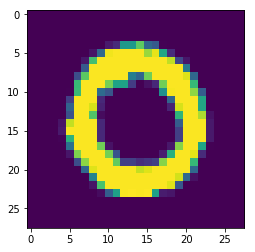

In [22]:
train_dataset = pd.read_csv(r"C:\Users\india\mnist digit recognition\train.csv" )
train_dataset = np.array(train_dataset)
x_images = train_dataset[: , 1:]
x_images = x_images.reshape([-1 , 28 , 28 , 1])
y_label = train_dataset[: , 0]
plt.imshow(x_images[1].reshape([28 , 28]))

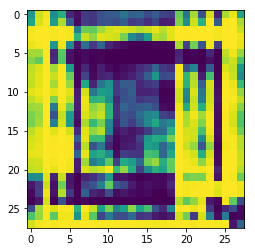

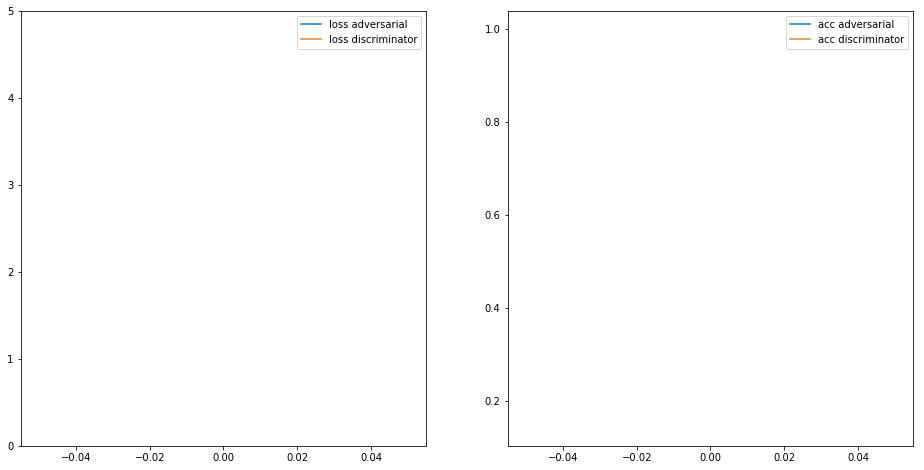

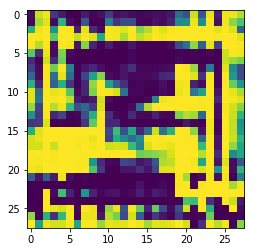

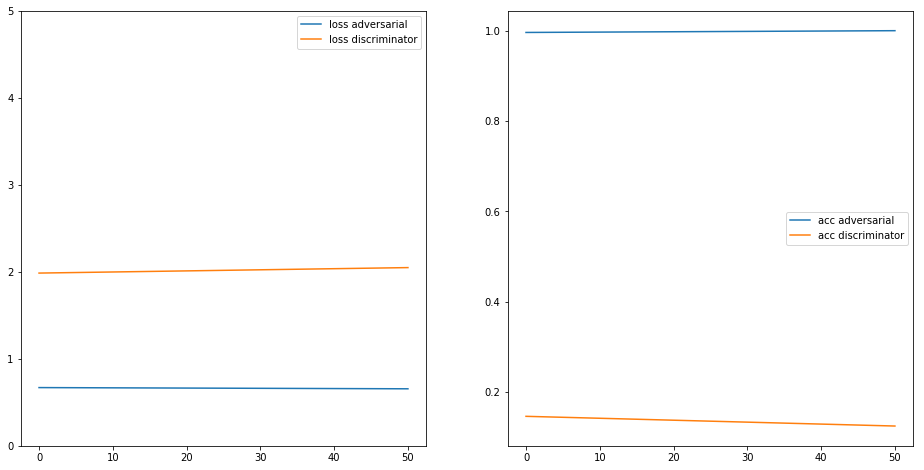

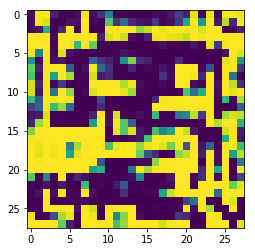

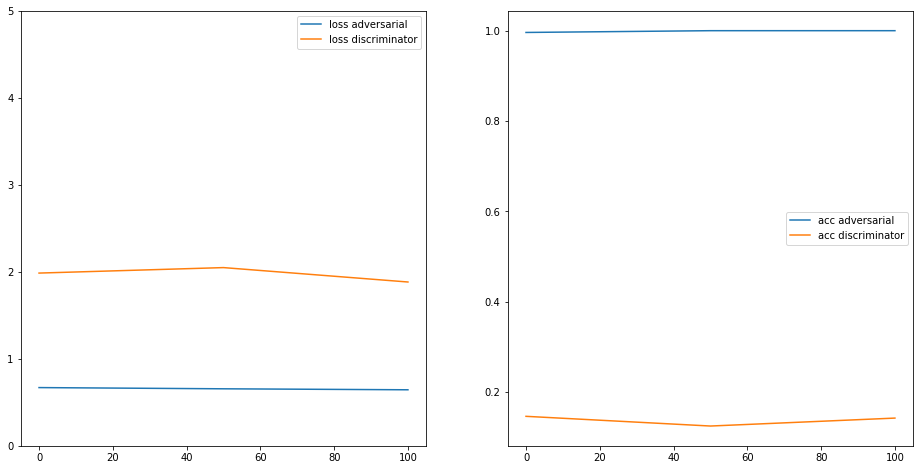

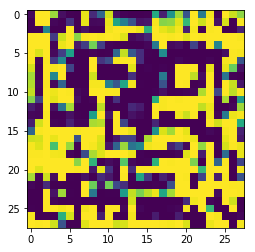

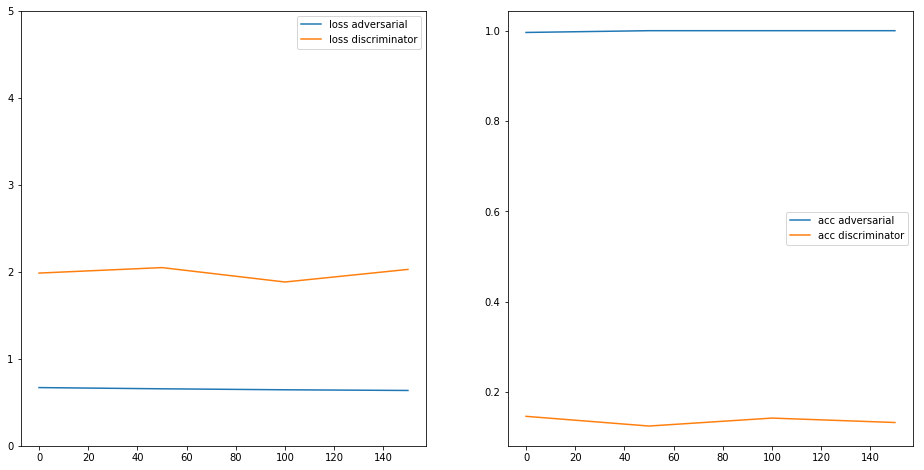

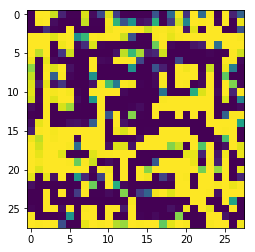

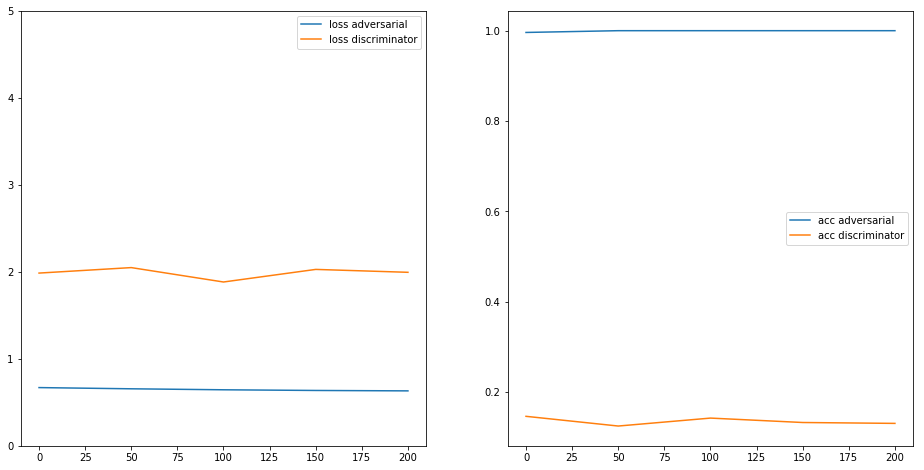

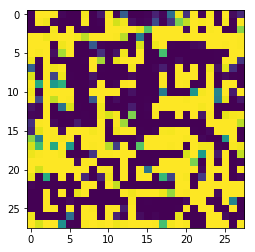

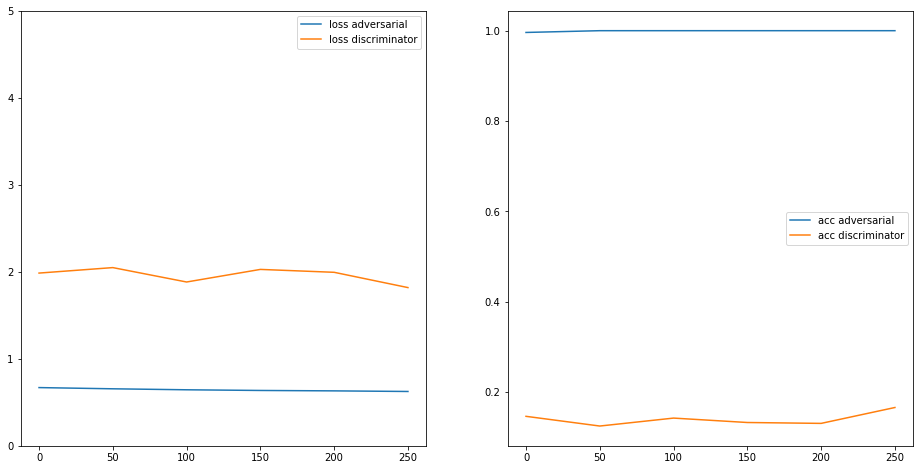

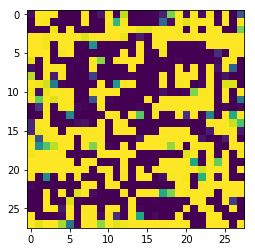

In [26]:
batch_size = 256

plot_iteration = []
loss_adv = []
loss_dis = []
acc_adv = []
acc_dis = []


for i in range(300):
    x = x_images[np.random.randint( 0 , x_images.shape[0] , batch_size ) , : , : , :]
    y = np.ones([2*batch_size , 1])

    x_noise = np.random.uniform(-1 , 1 , size = [batch_size , 100])
    x_fake = net_generator.predict(x_noise)
    x = np.concatenate((x , x_fake))
    y[batch_size: , : ] = 0

    plt.imshow(x_fake[1].reshape([28 , 28]))
    x_fake.shape



    d_stats = model_discriminator.train_on_batch(x , y)

    y_noise = np.ones([batch_size , 1])
    x_noise = np.random.uniform(-1 , 1 , size = [batch_size , 100])

    a_stats = adversial_net.train_on_batch(x_noise , y_noise)
    
    if i % 50 == 0:
        plot_iteration.append(i)
        loss_adv.append(a_stats[0])
        loss_dis.append(d_stats[0])
        acc_adv.append(a_stats[1])
        acc_dis.append(d_stats[1])

        
        fig, (ax1, ax2) = plt.subplots(1,2)
        fig.set_size_inches(16, 8)

        ax1.plot(plot_iteration, loss_adv, label="loss adversarial")
        ax1.plot(plot_iteration, loss_dis, label="loss discriminator")
        ax1.set_ylim([0,5])
        ax1.legend()

        ax2.plot(plot_iteration, acc_adv, label="acc adversarial")
        ax2.plot(plot_iteration, acc_dis, label="acc discriminator")
        ax2.legend()

        plt.show()